In [15]:
import re 
import string
import unicodedata
import sys

STOPWORDS = [u"ấy", u"bị", u"bởi", u"cả", u"các", u"cái", u"cần", u"càng", u"chỉ", u"chiếc", u"cho", u"chứ", u"chưa", 
             u"chuyện", u"có", u"có_thể", u"cứ", u"của", u"cùng", u"cũng", u"đã", u"đang", u"đây", u"để", u"đến_nỗi", 
             u"đều", u"điều", u"do", u"đó", u"được", u"dưới", u"gì", u"khi", u"không", u"là", u"lại", u"lên", u"lúc", 
             u"mà", u"mỗi", u"một cách", u"này", u"nên", u"nếu", u"ngay", u"nhiều", u"như", u"nhưng", u"những", u"nơi", 
             u"nữa", u"phải", u"qua", u"ra", u"rằng", u"rất", u"rồi", u"sau", u"sẽ", u"so", u"sự", u"tại", u"theo", 
             u"thì", u"trên", u"trước", u"từ", u"từng", u"và", u"vẫn", u"vào", u"vậy", u"vì", u"việc", u"với", u"vừa",
             u"_num", u"wwdateww", u"wwtimeww", u"wwemailww", u"wwipww", u"wwurlww", u"wwnumberww"
            ]

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P') and i != 45 and i!= 95)

def vi_trans_unicode(su):
    return su.translate(tbl)

def vi_strip_text2(s):
    s = re.sub(r"&amp;", "", s)
    s = vi_trans_unicode(s)
    s = re.sub(r"<([^>]+)>", "", s)
    s = re.sub(r"(\s|\\n|\\r|\\t)+", " ", s)
    s = re.sub(r"__+", "_", s)
    s = re.sub(r"--+", "-", s)
    s = ' '.join([w if not w[0].isdigit() else u"wwNUMBERww" for w in s.strip().split()])
    return s

def vi_clean3(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words]
    return ' '.join(words)

def vi_remove_stop_1char(line):
    words = line.replace('.','').strip().split()
    words = [w for w in words if w not in STOPWORDS and len(w) > 1]
    return ' '.join(words)

def vi_clean4(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words if len(w) > 1]
    words = [w for w in words if w not in STOPWORDS]
    return ' '.join(words)

import requests
import codecs
import json

tok_url = "http://192.168.0.215:8081/api/v1.0/document/filter?"

def get_tokens(tok_url, data):
    try:
        rq = requests.post(tok_url, data=vi_remove_stop_1char(vi_clean3(vi_strip_text2(data))).encode('utf-8'))
        if rq.content:
            tok_doc = ' '.join(json.loads(rq.content)['sentences'])
        else:
            tok_doc = None
        return tok_doc
    except Exception, e:
        print e

## Loading Test

In [16]:
import requests
import codecs
import json
import pandas as pd

In [17]:
df = pd.read_json("/home/laampt/nlp/data/private/df_test.json")

In [18]:
df.head(5)

,Doc,Doc_Clean,Num_Words,Target
0,"Công bố kết quả kiểm tra, giám sát, đôn đốc cô...",công_bố kết_quả kiểm_tra giám_sát đôn_đốc công...,708,0
1,VTV1 KHÉO LÉO QUẢNG BÁ CUỘC GẶP CỦA TỔNG THỐNG...,vtv1 khéo_léo quảng_bá cuộc gặp của tổng_thống...,97,1
10,"Đẩy mạnh xoá đói, giảm nghèo, hạn chế phân hoá...",đẩy_mạnh xoá đói giảm nghèo hạn_chế phân_hoá g...,1136,0
100,CON CỦA THỦ TƯỚNG NGUYỄN TẤN DŨNG\n\n Chúng tô...,con của thủ_tướng nguyễn tấn dũng chúng_tôi bắ...,1249,1
101,Dốc toàn lực tìm người mất tích vụ tai nạn lò ...,dốc toàn lực tìm người mất_tích vụ tai_nạn lò ...,303,0


In [19]:
test_docs = df.Doc_Clean.values
test_docs = [vi_clean4(vi_strip_text2(doc)) for doc in test_docs]
test_labels = df.Target.values

print len(test_docs), len(test_labels)

140 140


In [20]:
test_docs_list = [doc.split() for doc in test_docs]

## Loading models

In [21]:
from sklearn.externals import joblib

lr_tfidf = joblib.load("/home/laampt/nlp/train/estimator/docsent/lr_tfidf_914e_91auc.pkl")
svc_tfidf = joblib.load("/home/laampt/nlp/train/estimator/docsent/svc_tfidf_914e_91auc.pkl")
vectorizer_tfidf = joblib.load("/home/laampt/nlp/train/estimator/docsent/vectorizer_tfidf_914e_91auc.pkl")

## Tranform

In [22]:
test_data_features2 = vectorizer_tfidf.transform(test_docs)
test_data_features2 = test_data_features2.toarray()

In [23]:
print test_data_features2.shape, test_labels.shape

(140, 30000) (140,)


## Performance report

In [24]:
from sklearn import metrics
import numpy as np

In [25]:
w =0.4
print "LR: {}, SVC: {}".format(w,1-w)
mega_predictions = []
for vec in test_data_features2:
    prediction = lr_tfidf.predict(vec) * w + svc_tfidf.predict(vec) * (1-w)
    prediction = 1 if (prediction[0] > 0.5) else 0
    mega_predictions.append(prediction)
print 'Mega Combinator:\n{}'.format(metrics.classification_report(test_labels, mega_predictions))
print('Mega Classifier: {:.2f} AUC'.format(metrics.roc_auc_score(test_labels, mega_predictions)))
print

LR: 0.4, SVC: 0.6
Mega Combinator:
             precision    recall  f1-score   support

          0       0.93      0.93      0.93        81
          1       0.90      0.90      0.90        59

avg / total       0.91      0.91      0.91       140

Mega Classifier: 0.91 AUC



## V05

LR: 0.4, SVC: 0.6
Mega Combinator:
             precision    recall  f1-score   support

          0       0.90      0.94      0.92        81
          1       0.91      0.86      0.89        59

avg / total       0.91      0.91      0.91       140

Mega Classifier: 0.90 AUC

## Comment on improvement

Overall AUC increased 1%. 90 --> 91

- increase 4% Recall of black class, 3% precision of white class
- trade off: decrease 1% of black precision, and recall of white

If we focus on HOW WELL to catch black ones, V06 is quite better on 4% recall up/ 1% of AUC 

## Visualization

In [26]:
%matplotlib inline 

import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

import seaborn as sns

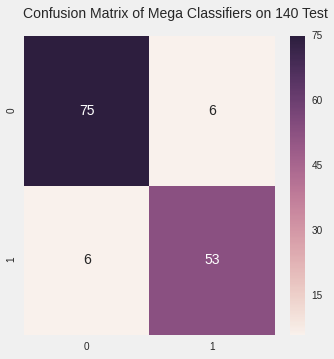

In [27]:
cm = metrics.confusion_matrix(test_labels, np.array(mega_predictions))

fix, ax = plt.subplots(figsize=(5, 5))
plt.suptitle('Confusion Matrix of Mega Classifiers on 140 Test ')
plt.subplot(1, 1, 1)
sns.heatmap(cm, annot=True,  fmt='');

In [ ]:
for i, label in enumerate(mega_predictions):
    if mega_predictions[i] != test_labels[i]: 
        print test_docs[i]
        print ">> True: {} | Predict: {}".format(test_labels[i], mega_predictions[i])
        print '-' * 80

## Benchmark

In [29]:
%timeit lr_tfidf.predict(vec)

The slowest run took 4.69 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 55.7 µs per loop


In [30]:
%timeit svc_tfidf.predict(vec)

10000 loops, best of 3: 55.8 µs per loop


In [31]:
%load_ext memory_profiler

In [32]:
%memit lr_tfidf.predict(vec)

peak memory: 208.67 MiB, increment: 0.20 MiB


In [33]:
%memit svc_tfidf.predict(vec)

peak memory: 208.71 MiB, increment: 0.04 MiB


## Sanity check

In [34]:
def mega_prediction(feed, vectorizer_tfidf, lr_tfidf10, svc_tfidf10, w=0.4):
    """
    Input: given raw feed, vectorizer, lr, svm classifier
    Output: 1 if feed is user opinion alike else 0
    """
    s_test_clean = vi_remove_stop_1char(vi_clean3(vi_strip_text2(feed)))
    vec = vectorizer_tfidf.transform([s_test_clean]).toarray()[0,:].T
    prediction = lr_tfidf10.predict(vec) * w + svc_tfidf10.predict(vec) * (1-w)
    prediction = 1 if (prediction[0] > 0.5) else 0
    return prediction

In [ ]:
INPUT = u"""vtv1 khéo_léo quảng_bá cuộc gặp tổng_thống obama blogger điếu_cày trong bản_tin buổi sáng mình ngày vtv1 khéo_léo đưa đoạn phim gặp_gỡ giữa tổng_thống hoa_kỳ barack obama blogger điếu_cày nguyễn văn hải nhằm đánh_dấu ngày tự_do báo_chí năm nay bằng cách lồng một tin_vắn nội_dung khác chúng_tôi cách khôn_khéo đưa_tin vtv1 nhằm tôn_vinh ngày tự_do báo_chí trong tình_trạng báo_chí truyền_thông việt_nam luôn luôn bóp_nghẹt ban tuyên_giáo trung_ương bộ_chính_trị đảng cộng_sản việt_nam cảm_ơn btc khánh trang ban biên_tập chương_trình chào buổi sáng vtv1"""
print INPUT
print "PREDICT: {}".format(mega_prediction(INPUT, vectorizer_tfidf, lr_tfidf, svc_tfidf))